# Constructing a corpus of cigarette adverts

In [3]:
import pandas as pd
import os
from tqdm import tqdm
import re
from itertools import chain
import unidecode
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt


In [2]:
%matplotlib inline

In [71]:
data_path = '../../../datasets/newspapers_clean/'
figures_path = '../ms/figures/'

In [4]:
keywords = [r'[a-z]*[cs]igaret\w*'] #this regular expressions captures spelling variations of cigarette in Dutch
pattern = '|'.join(keywords)


## Functions

In [133]:
def plot_ad_curve(df, freq, rolling=5):
    
    start_year = df['years'].min()
    end_year = df['years'].max()

    total_counts = df.groupby(pd.Grouper(key='date', freq=freq))['page'].count()
    
    plt.figure(figsize=(16, 10), dpi=80)
    for keyword in ['american', 'british', 'egyptian', 'virginia',
             'turkish', 'russian']:
        print(keyword)
        count = df.groupby(pd.Grouper(key='date', freq=freq))[keyword].sum().rolling(rolling).sum()
        rel_count = (count / total_counts) * 1000
        plt.plot(rel_count, lw=3, label=keyword)
    plt.legend(prop={'size': 15})
    plt.title('Signiers of Nationality in Cigarette Advertisements, 1890-1990', fontsize=22)
    plt.yticks(fontsize=12, alpha=.7)
    plt.ylabel(r'Counts per 1,000 Ads', fontsize=15, alpha=.7)
    plt.xlabel(r'Year', fontsize=15, alpha=.7)
    plt.grid(axis='both', alpha=.3)
    plt.gca().spines["top"].set_alpha(0.0)    
    plt.gca().spines["bottom"].set_alpha(0.3)
    plt.gca().spines["right"].set_alpha(0.0)    
    plt.gca().spines["left"].set_alpha(0.3)
    plt.savefig(os.path.join(figures_path, 'cigarette_nationality.jpg'))
    
def find_context_word(text, span, keywords, context_term):
    '''
    Finding whether words appear in a certain span. 
    text = input text
    span = size of span
    keywords = central keyword
    context_term = words that can appear in context
    '''
    context = []
    counter = 0
    found_keywords = re.findall('|'.join(keywords),text)
    for keyword in found_keywords:
        list_words = text.split()
        for i in chain(range(span[0],0), range(1, span[1] + 1)):
            try:
                context.append(list_words[list_words.index(keyword) + i])
            except IndexError:
                pass

    matches = len(re.findall('|'.join(context_term), ' '.join(context)))
    counter += matches
    return counter


In [ ]:
# This goes through the newspaper data and selects only ads with word cigarette in them. 
# Also, does some other preprocessing

results = []
subdirs = ['ads']
for root, dirs, files in os.walk(data_path):
    if all(subdir in dirs for subdir in subdirs):
        results.append(os.path.join(root,subdirs[0]))

# selected_papers = ['nn']
regex_pat = re.compile(r'[^a-zA-Z\s]', flags=re.IGNORECASE)
meta_data = []

for path in results:
    print(path)
    frame = []
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
    onlyfiles = [f for f in onlyfiles if f.endswith('.tsv')]
    newspaper_name = path.split('/')[5]

    newspaper_years = []
    for filename in tqdm(onlyfiles):
        print(filename)
        df = pd.read_csv(os.path.join(path, filename), index_col=None, delimiter='\t')
        df['ocr'] = df['ocr'].astype(str)
        df['ocr'] = df['ocr'].apply(lambda x: unidecode.unidecode(x)) 
        df['ocr'] = df['ocr'].str.replace(regex_pat, '') #only words
        df['ocr'] = df['ocr'].str.findall(r'\w{2,}').str.join(' ').str.lower() #only words longer than 2 chars
        df['identifier'] = df['ocr_url'].apply(lambda x: x.split('/')[:][3][12:-4])
        df = df[df['ocr'].str.contains(pattern, na=False)]
        #ocr = df[['identifier', 'ocr']]
        df['newspaper_name'] = newspaper_name
        #ocr.to_csv(os.path.join(path, 'ocr_' + filename), sep='\t', index=None)
        newspaper_years.append(df)
    frame = pd.concat(newspaper_years, axis=0, ignore_index=True)
    meta_data.append(frame)

cigarette_corpus = pd.concat(meta_data, axis=0, ignore_index=True)



In [1]:
cigarette_corpus = pd.read_csv('cigarette_corpus.tsv')
#cigarette_corpus.to_csv('cigarette_corpus.tsv')

NameError: name 'pd' is not defined

In [30]:
#load meta_data

meta_data = pd.read_csv('full_metadata.csv')
meta_data['date'] = pd.to_datetime(meta_data['date'])

selected_papers = ['algemeen_handelsblad', 'detijd', 'het_volk',
                  'nieuwe_rotterdamsche_courant', 'nrc', 'parool',
                  'telegraaf', 'trouw', 'vaderland', 'vk', 'vv']

meta_data = meta_data[meta_data['newspaper_name'].isin(selected_papers)]

meta_data['years'] = pd.DatetimeIndex(meta_data['date']).year
meta_data = meta_data[meta_data['years'] <= 1990]

In [37]:
cigarette_corpus = cigarette_corpus[cigarette_corpus['newspaper_name'].isin(selected_papers)]
cigarette_corpus['years'] = pd.DatetimeIndex(cigarette_corpus['date']).year
cigarette_corpus = cigarette_corpus[cigarette_corpus['years'] <= 1990]
cigarette_corpus['date'] = pd.to_datetime(cigarette_corpus['date'])

In [47]:
freq = 'Y'

meta_data_count = meta_data.groupby(pd.Grouper(key='date', freq=freq))['page'].count().rolling(5).sum()
cigarette_corpus_count = cigarette_corpus.groupby(pd.Grouper(key='date', freq=freq))['page'].count().rolling(5).sum()

In [50]:
rel_count = cigarette_corpus_count / meta_data_count

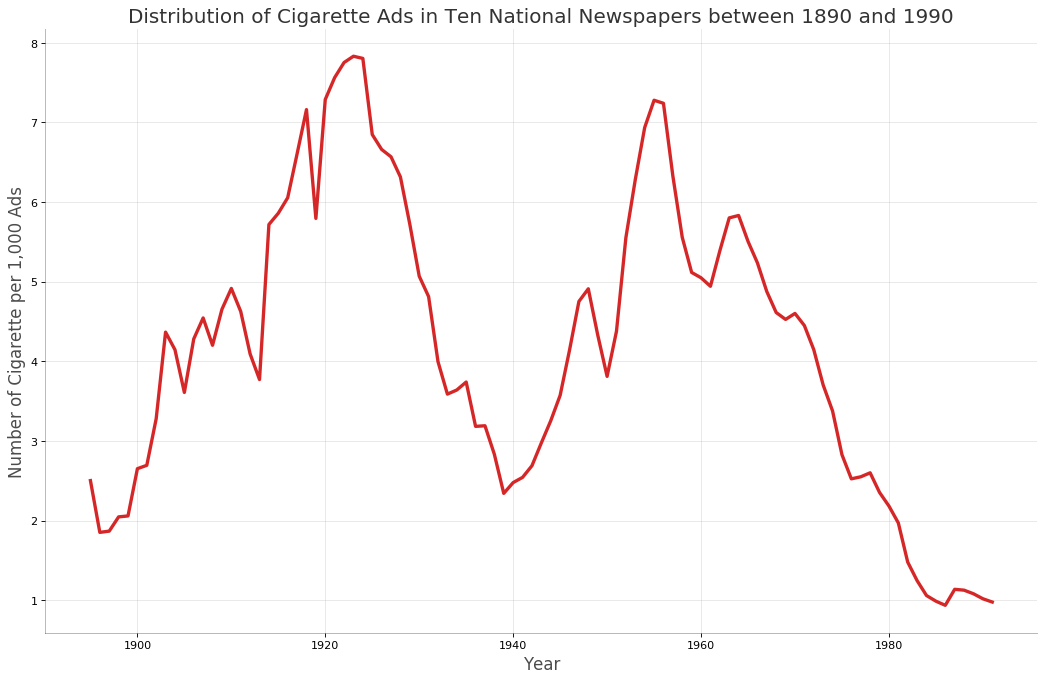

In [132]:

df = rel_count * 1000

plt.figure(figsize=(16, 10), dpi=80)
plt.plot(df.index, df.values, color='tab:red', lw=3)


plt.title('Distribution of Cigarette Ads in Ten National Newspapers between 1890 and 1990', fontsize=18, alpha=.8)
plt.grid(axis='both', alpha=.3)

plt.ylabel(r'Number of Cigarette per 1,000 Ads', fontsize=15, alpha=.7)
plt.xlabel(r'Year', fontsize=15, alpha=.7)
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)  

plt.savefig(os.path.join(figures_path, 'cigarette_ads.jpg'))
plt.show()

## counting contex terms

In [73]:
context_term = [r'ameri[ck]a{1,2}[a-z]*', 'vere{1,2}nigde staten', 'u.s.a', 'usa']
context_term2 = [r'brits[a-z]*', 'british', 'english', 'united kingdom', 'engeland', 'vere{1,2}nigd koninkrijk']
context_term3 = [r'egypt[a-z]*']
context_term4 = [r'virginia[a-z]*']
context_term5 = [r'turkish', 'turkije', 'turks[a-z]*']
context_term6 = [r'rusland', 'russian', 'russisch[a-z]*']
span = (-5, 5)
    

In [117]:
cigarette_corpus['american'] = cigarette_corpus['ocr'].apply(lambda x: find_context_word(x, span, keywords, context_term))
cigarette_corpus['british'] = cigarette_corpus['ocr'].apply(lambda x: find_context_word(x, span, keywords, context_term2))
cigarette_corpus['egyptian'] = cigarette_corpus['ocr'].apply(lambda x: find_context_word(x, span, keywords, context_term3))
cigarette_corpus['virginia'] = cigarette_corpus['ocr'].apply(lambda x: find_context_word(x, span, keywords, context_term4))
cigarette_corpus['turkish'] = cigarette_corpus['ocr'].apply(lambda x: find_context_word(x, span, keywords, context_term5))
cigarette_corpus['russian'] = cigarette_corpus['ocr'].apply(lambda x: find_context_word(x, span, keywords, context_term6))

american
british
egyptian
virginia
turkish
russian


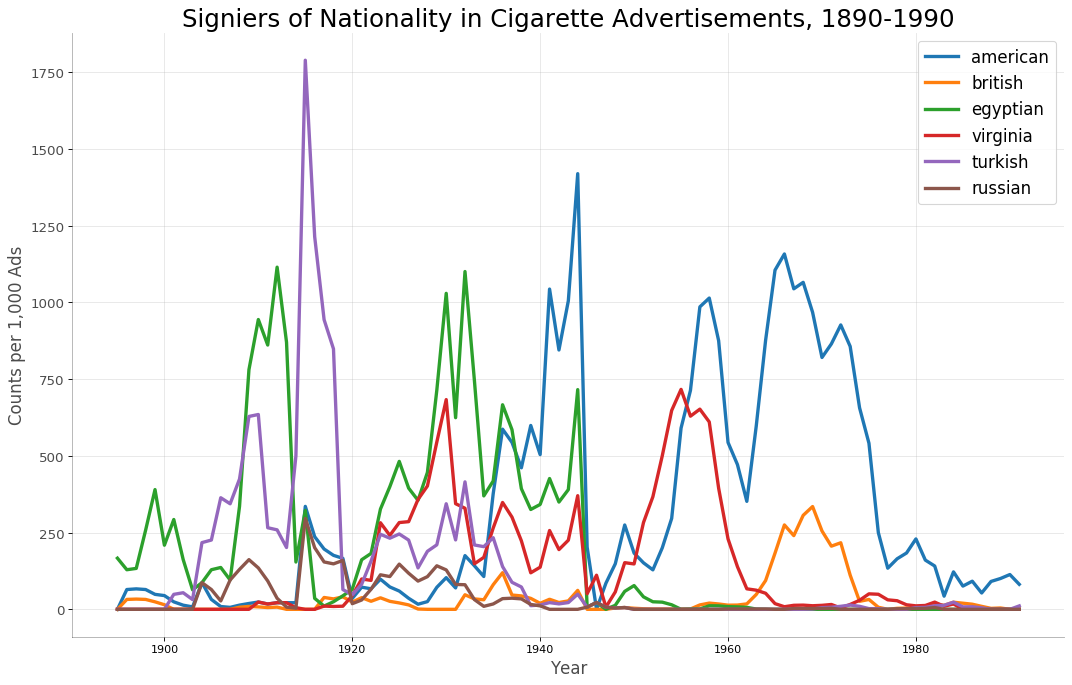

In [134]:
plot_ad_curve(cigarette_corpus,'Y', rolling=5)